In [ ]:
! pip install --upgrade google-cloud-bigquery-storage

In [26]:
import google, pathlib, dataclasses, typing, numpy as np, pandas as pd, geopandas as gpd, networkx as nx
import matplotlib.pyplot as plt, plotly.express as px 
from shapely.ops import orient
from google.cloud import aiplatform, bigquery
from google.cloud.bigquery_storage import BigQueryReadClient, types
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')

proj_id = 'cmat-315920'
root_path = pathlib.Path('/home/jupyter')

cred, proj = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
bqclient = bigquery.Client(credentials = cred, project = proj)
crs_map = 'NAD83'
crs_area = 'ESRI:102003'
crs_length = 'ESRI:102005'
rng = np.random.default_rng(42)

class myGeoDataFrame(gpd.GeoDataFrame):
    def set_crs(self, crs='NAD83'):
        self['centroid'] = self['centroid'].to_crs(crs)
        self.to_crs(crs, inplace=True)
        return self

    def get_perim(self, col=None):
        X = self.set_crs(crs_length)
        if col:
            X = self.dissolve(by=col)
        return X.length / 1000

    def get_area(self, col=None):
        X = self.set_crs(crs_area)
        if col:
            X = X.dissolve(by=col)
        return X.area / (1000**2)
    
    def copy(self):
        return self.__class__(super().copy())


@dataclasses.dataclass
class Gerry:
    abbr      : str
    yr        : int
    min_degree: int = 2
    clr_seq   : typing.Any = tuple(px.colors.qualitative.Antique)
    # px.colors.qualitative.swatches() # show available color schemes
    # input is WKT in NAD83 - https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2020/TGRSHP2020_TechDoc_Ch3.pdf
    # use ESRI:102003 for area calculations - https://epsg.io/102003
    # use ESRI:102005 for length calculations - https://epsg.io/102005
    
    def __getitem__(self, key):
        return self.__dict__[key]

    def __setitem__(self, key, val):
        self.__dict__[key] = val
    
    def __post_init__(self):
        self.congress = int((self.yr-1786)/2)
        
        def rgb_to_hex(c):
            if c[0] == '#':
                return c
            else:
                return '#%02x%02x%02x' % tuple(int(rgb) for rgb in c[4:-1].split(', '))
        self.clr_seq = [rgb_to_hex(c) for c in self.clr_seq]    
        
        query_str = f"""
        select
            state_fips_code as fips
            , state_postal_abbreviation as abbr
            , state_name as name
        from
            bigquery-public-data.census_utility.fips_codes_states
        """
        states = bqclient.query(query_str).result().to_dataframe()
        self.__dict__.update(states[states['abbr']==self.abbr].iloc[0])
        self.run_path = root_path / f'simulations/{self.yr}/{self.abbr}'
        self.run_path.mkdir(parents=True, exist_ok=True)
        self.files = {'bgs'  : self.run_path / 'bgs.parquet',
                      'pairs': self.run_path / 'pairs.parquet',
                      'graph': self.run_path / 'graph.gpickle',
                      }
        
    def read_data(self, variable):
        """Check if the data already exists so we can reuse it without pulling it again"""
        try:
            # Does the object already have it?
            self[variable]
        except:
            # If not, is it stored in a local file?
            print(f'Getting {variable} - ', end='')
            try:
                self[variable] = myGeoDataFrame(gpd.read_parquet(self.files[variable]))
                print('found geoparquet file')
            except:
                try:
                    self[variable] = pd.read_parquet(self.files[variable])
                    print('found parquet file')
                except:
                    try:
                        self[variable] = nx.read_gpickle(self.files[variable])
                        print('found gpickle file')
                    except:
                        # Nope, there's no file with that data ... gotta go get it
                        print('not found - creating')
                        return False
        return True

    def get_bgs(self):
        if not self.read_data('bgs'):
            query_str = f"""
            select
                --geo_id structure - https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html
                geo.geo_id
                , cast(substring(geo.geo_id, 0 , 2) as int) as state_fips
                , cast(substring(geo.geo_id, 3 , 3) as int) as county_fips
                , cast(substring(geo.geo_id, 5 , 6) as int) as tract_ce
                , cast(substring(geo.geo_id, 12, 1) as int) as blockgroup_ce
                , centroids.lon
                , centroids.lat
                , cast(cd.cd as int) as cd
                , cast(acs.total_pop as int) as pop
                , geo.geometry
            from (
                -- get shapes
                select
                    geo_id
                    --state_fips_code as state_fips
                    --, county_fips_code as county_fips
                    --, tract_ce
                    --, blockgroup_ce
                    --, lsad_name
                    --, mtfcc_feature_class_code.
                    --, functional_status
                    --, area_land_meters
                    --, area_water_meters
                    --, internal_point_lat as lat
                    --, internal_point_lon aas loni
                    --, internal_point_geom
                    , blockgroup_geom as geometry
                from
                    bigquery-public-data.geo_census_blockgroups.blockgroups_{self.fips}
                )  as geo
            inner join (
                -- get shapes demographic data
                select distinct
                    geo_id
                    , total_pop
                from
                    bigquery-public-data.census_bureau_acs.blockgroup_{self.yr}_5yr
                ) as acs
            on
                geo.geo_id = acs.geo_id
            inner join (
                -- get population weighted centroids
                -- must build geo_id because data source does not include it
                select distinct
                    concat( 
                        lpad(cast(STATEFP as string), 2, "0"),
                        lpad(cast(COUNTYFP as string), 3, "0"),
                        lpad(cast(TRACTCE as string), 6, "0"),
                        lpad(cast(BLKGRPCE as string), 1, "0")
                        ) as geo_id
                    --, POPULATION as pop
                    , LONGITUDE as lon
                    , LATITUDE as lat
                from
                    {proj_id}.BLOCK_CENTROIDS.block_centroid_{self.fips}
                ) as centroids
            on
                geo.geo_id = centroids.geo_id
            inner join (
                -- get congressional district
                -- at block level -> must aggregate to blockgroup
                -- 7141 (3%) of blockgroups span multiple congressional districts
                -- We assign that entire bg to the cd with the most blocks
                select
                    *
                from (
                    select
                        A.*
                        , rank() over (partition by A.geo_id order by A.num_blocks_in_cd desc) as r
                    from (
                        select
                            left(BLOCKID, 12) as geo_id   -- remove last 4 char to get blockgroup geo_id
                            , CD{self.congress} as cd
                            , count(*) as num_blocks_in_cd
                        from 
                            {proj_id}.Block_Equivalency_Files.{self.congress}th_BEF
                        group by
                            1, 2
                        ) as A
                    ) as B
                where
                    r = 1
                ) as cd
            on
                geo.geo_id = cd.geo_id
            """
            bgs = bqclient.query(query_str).result().to_dataframe().set_index('geo_id')
            bgs['geometry'] = gpd.GeoSeries.from_wkt(bgs['geometry']).apply(lambda p: orient(p, -1))
            bgs = myGeoDataFrame(bgs, geometry='geometry', crs=crs_map)
            bgs['centroid'] = gpd.points_from_xy(bgs['lon'], bgs['lat'], crs=crs_map)
            bgs['area'] = bgs.get_area()
            bgs['perim'] = bgs.get_perim()
            self['bgs'] = bgs
        self['bgs'].to_parquet(self.files['bgs'])

    def draw_map(self):
        self.get_bgs()
        df = self.bgs.copy().set_crs(crs_map).sort_values('cd')
        df['geometry'] = df['geometry'].simplify(0.001)
        df['cd_pop'] = df.groupby('cd')['pop'].transform('sum')
        df['cd_label'] = df['cd'].astype(str) + ': pop=' + df['cd_pop'].astype(str)
        fig = px.choropleth(df,
                            geojson = df['geometry'],
                            locations = df.index,
                            color = "cd_label",
                            color_discrete_sequence = self.clr_seq,
                            hover_data = {'area': ':.0f',
                                          'pop' : ':',
                                         }
                           )
        fig.update_geos(fitbounds="locations", visible=True)
        fig.update_layout({
            'title' : {'text':f'{self.name} {self.yr}', 'x':0.5, 'y':1.0},
            'margin' : {"r":0,"t":20,"l":0,"b":0},
        })
        fig.show()
        return fig

    def get_pairs(self):
        if not self.read_data('pairs'):
            self.get_bgs()
            cols = ['geo_id', 'geometry', 'centroid']
            A = self.bgs.reset_index().query('pop > 0')[cols]
            pairs = A.merge(A, how='cross').query('geo_id_x < geo_id_y').reset_index(drop=True)
            pairs['distance']     = pairs.set_geometry('centroid_x').distance(    pairs.set_geometry('centroid_y'), align=False)
            pairs['perim_shared'] = pairs.set_geometry('geometry_x').intersection(pairs.set_geometry('geometry_y'), align=False).length
            pairs['touch'] = pairs['perim_shared'] > 1
            pairs['transit_time'] = pairs['distance'] / 1341 * rng.uniform(0.5, 1.5)  # 50 mph → 1341 m/min
            pairs.drop(columns=[c+z for c in cols[1:] for z in ['_x', '_y']], inplace=True)
            self['pairs'] = pd.concat([pairs, pairs.rename(columns={'geo_id_x':'geo_id_y', 'geo_id_y':'geo_id_x'})])
        self['pairs'].to_parquet(self.files['pairs'])

    def edges_to_graph(self, edges):
        edge_attr = ['perim_shared', 'touch', 'distance', 'transit_time']
        return nx.from_pandas_edgelist(edges, source='geo_id_x', target='geo_id_y', edge_attr=edge_attr)

    def get_cds(self):
        self.get_graph()
        self.cds = dict()
        for node, cd in self.graph.nodes.data('cd'):
            try:
                self.cds[cd].update({node})
            except:
                self.cds[cd] = {node}
        return self.cds
            
    def connect_cds(self):
        self.get_cds()
        for cd, nodes in self.cds.items():
            while True:
                H = self.graph.subgraph(nodes)
                components = list(nx.connected_components(H))
                print(f'CD {cd} has {len(components)} connected components')
                if len(components) == 1:
                    break
                mask = self.pairs['geo_id_x'].isin(components[0]) & self.pairs['geo_id_y'].isin(components[1])
                i = self.pairs.loc[mask]['distance'].idxmin()
                edges = self.pairs.loc[i]
                self.graph.update(self.edges_to_graph(edges))
        return self.graph

    def make_min_degree(self):
        self.get_graph()
        edges = list()
        for node, deg in self.graph.degree:
            n = self.min_degree - deg
            if n > 0:
                print(node,deg)
                mask = (self.pairs['geo_id_x'] == node) & ~(self.pairs['geo_id_y'].isin(self.graph.neighbors(node)))
                edges.append(self.pairs[mask].nsmallest(n, 'distance'))
        if len(edges) > 0:
            self.graph.update(self.edges_to_graph(pd.concat(edges)))
        return self.graph

    def get_graph(self):
        if not self.read_data('graph'):
            self.get_pairs()
            edges = self.pairs.query('touch')
            self.graph = self.edges_to_graph(edges)
            node_attr = ['area', 'perim', 'cd', 'pop']
            nx.set_node_attributes(self.graph, self.bgs[node_attr].to_dict('index'))
            self.connect_cds()
            self.make_min_degree()
        nx.write_gpickle(self['graph'], self.files['graph'])

    def draw_graph(self, layout=nx.spring_layout):
        self.get_cds()
        pos = layout(self.graph)
        for cd, nodes in self.cds.items():
            H = self.graph.subgraph(nodes)
            nx.draw_networkx_nodes(H, pos=pos, node_size=10, node_color=self.clr_seq[cd-1])
        nx.draw_networkx_edges(self.graph, pos=pos)
        plt.show()

Getting bgs - found geoparquet file


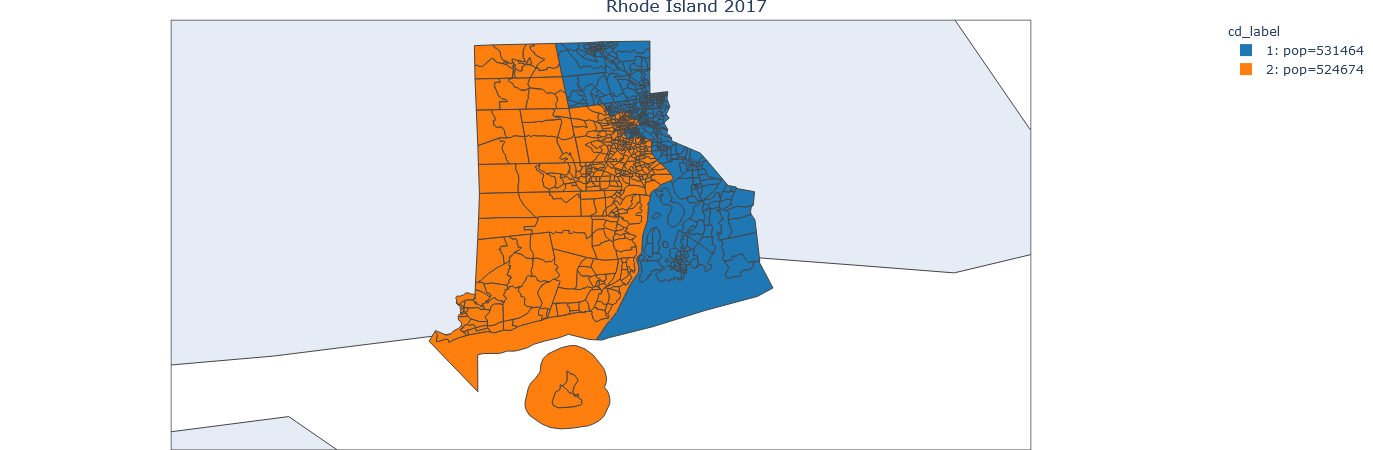

Getting graph - found gpickle file


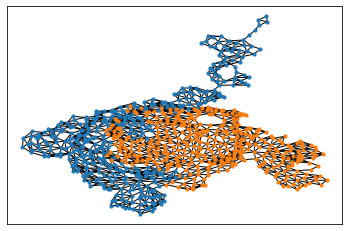

In [28]:
g = Gerry(abbr='RI', yr=2017, clr_seq=px.colors.qualitative.D3)
g.draw_map()
g.draw_graph(layout=nx.kamada_kawai_layout)

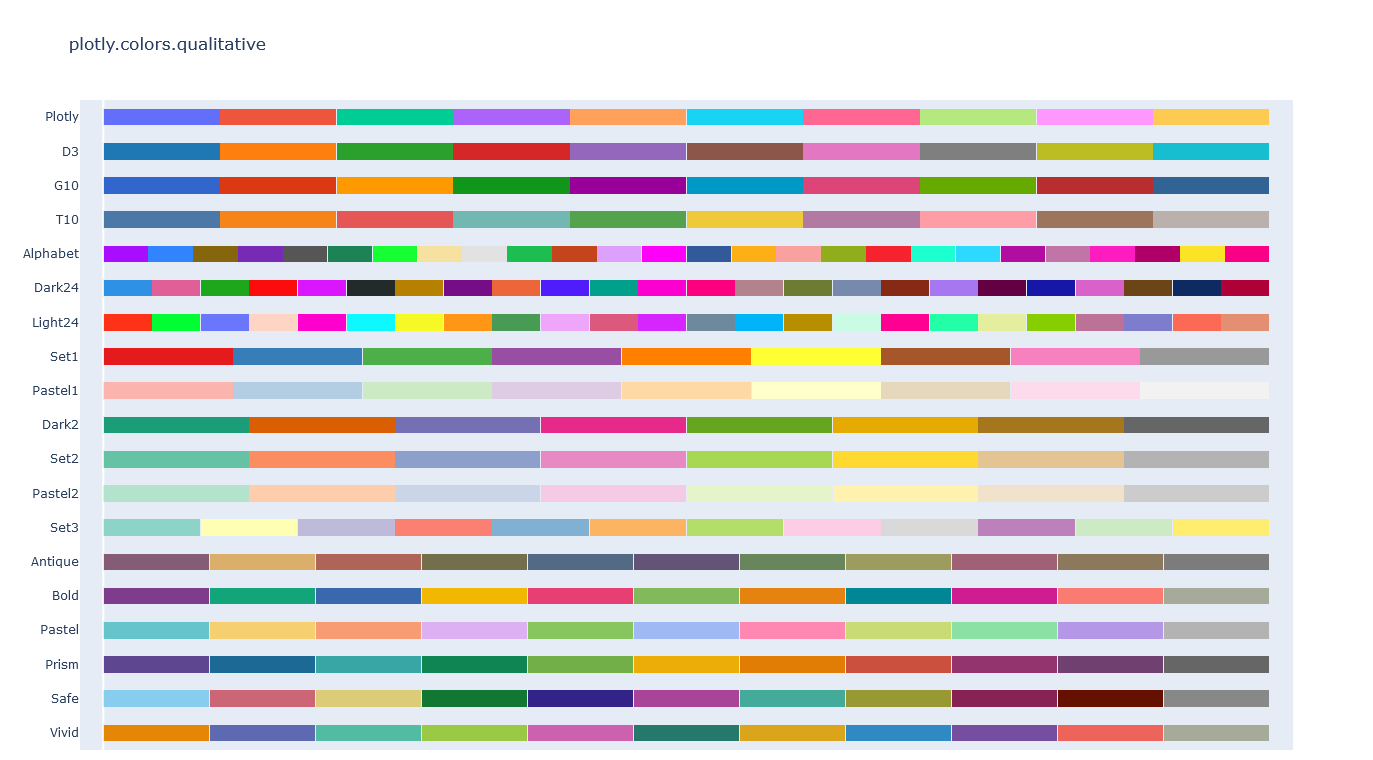

In [36]:
px.colors.qualitative.swatches()